In [242]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [160]:
# Load all datasets
train_proteins = pd.read_csv("./input/train_proteins.csv")
train_clinical = pd.read_csv("./input/train_clinical_data.csv")
train_peptides = pd.read_csv("./input/train_peptides.csv")
supplemental_clinical = pd.read_csv("./input/supplemental_clinical_data.csv")

In [161]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [162]:
train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [163]:
train_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [164]:
# Pivot the proteins and peptides tables so each protein and peptide is a feature
train_proteins = train_proteins.pivot_table(values="NPX", index="visit_id", columns="UniProt")
train_peptides = train_peptides.pivot_table(values="PeptideAbundance", index="visit_id", columns="Peptide")

In [165]:
# Merge the three tables
train = train_clinical.merge(train_proteins, on="visit_id", how="left")  \
                      .merge(train_peptides, on="visit_id", how="left")

In [166]:
train.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1


In [167]:
# Set the patient id as index
train = train.set_index(["patient_id"])

In [168]:
# An overview of the new tables
train.head(20)

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,55_0,0,10.0,6.0,15.0,NaN,NaN,11254.30,732430.0,39585.8,...,201158.0,16492.30,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
55,55_3,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_6,6,8.0,10.0,34.0,NaN,NaN,13163.60,630465.0,35220.8,...,171079.0,13198.80,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
55,55_9,9,8.0,9.0,30.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_12,12,10.0,10.0,41.0,0.0,On,15257.60,815083.0,41650.9,...,231772.0,17873.80,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
55,55_18,18,7.0,13.0,38.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_24,24,16.0,9.0,49.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_30,30,14.0,13.0,49.0,0.0,On,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55_36,36,17.0,18.0,51.0,0.0,On,13530.80,753832.0,43048.9,...,185290.0,18580.50,2659660.0,90936.9,679163.0,128593.0,203680.0,498621.0,52792.7,13973.7


In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 55 to 65043
Columns: 1202 entries, visit_id to YYWGGQYTWDMAK
dtypes: float64(1199), int64(1), object(2)
memory usage: 24.0+ MB


In [170]:
train = train.drop("visit_id", axis=1)

In [171]:
# Create a list of the ids of the patients
patient_id = list(train.index.unique())

In [172]:
# Check missing values
print(train.isna().sum().sum())

1962306


In [173]:
# Interpolate the missing data of every patient
for patient in patient_id:
    train.loc[patient] = train.loc[patient].interpolate(method="linear").fillna(method="bfill")

In [174]:
# Fill updrs and state of medication values
train.updrs_4 = train.updrs_4.fillna(0)
train.upd23b_clinical_state_on_medication = train.upd23b_clinical_state_on_medication.fillna("Off")

In [175]:
# Adjust updr4 values to possible values
train.updrs_4 = round(train.updrs_4)

In [176]:
# Check missing values after interpolate
print("Total missing values left: {}".format(train.isna().sum().sum()))
print(train.isna().sum().sort_values(ascending=False))

Total missing values left: 80927
EPQVYTLPPSRDELTK                                       1230
ALVQQMEQLR                                              778
AVGDKLPEC(UniMod_4)EADDGC(UniMod_4)PKPPEIAHGYVEHSVR     741
HYEGSTVPEK                                              683
QQLVETHMAR                                              662
                                                       ... 
DDNPNLPR                                                  0
DFADIPNLR                                                 0
DIPMNPMC(UniMod_4)IYR                                     0
DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR                  0
visit_month                                               0
Length: 1201, dtype: int64


In [177]:

# Fill the remaining na values with the mean of the columns
train = train.fillna(train.mean())

C:\Users\Javier\AppData\Local\Temp\ipykernel_7380\1508494664.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train = train.fillna(train.mean())


In [178]:
train.head(20)

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,10.0,6.0,15.0,0.0,On,11254.300000,732430.00,39585.80,41526.900,...,201158.00,16492.300,3810270.0,106894.000,580667.0,131155.000,165851.000,437305.0,46289.200,14898.400000
55,3,10.0,7.0,25.0,0.0,On,12208.950000,681447.50,37403.30,41410.950,...,186118.50,14845.550,3964895.0,110139.500,547764.0,117333.500,155229.000,447598.0,43168.450,17801.150000
55,6,8.0,10.0,34.0,0.0,On,13163.600000,630465.00,35220.80,41295.000,...,171079.00,13198.800,4119520.0,113385.000,514861.0,103512.000,144607.000,457891.0,40047.700,20703.900000
55,9,8.0,9.0,30.0,0.0,On,14210.600000,722774.00,38435.85,40529.150,...,201425.50,15536.300,4796830.0,114835.500,613338.0,120227.500,163185.000,455072.0,47386.400,21272.500000
55,12,10.0,10.0,41.0,0.0,On,15257.600000,815083.00,41650.90,39763.300,...,231772.00,17873.800,5474140.0,116286.000,711815.0,136943.000,181763.000,452253.0,54725.100,21841.100000
55,18,7.0,13.0,38.0,0.0,On,14825.900000,799770.25,42000.40,40698.375,...,220151.50,18050.475,4770520.0,109948.725,703652.0,134855.500,187242.250,463845.0,54242.000,19874.250000
55,24,16.0,9.0,49.0,0.0,On,14394.200000,784457.50,42349.90,41633.450,...,208531.00,18227.150,4066900.0,103611.450,695489.0,132768.000,192721.500,475437.0,53758.900,17907.400000
55,30,14.0,13.0,49.0,0.0,On,13962.500000,769144.75,42699.40,42568.525,...,196910.50,18403.825,3363280.0,97274.175,687326.0,130680.500,198200.750,487029.0,53275.800,15940.550000
55,36,17.0,18.0,51.0,0.0,On,13530.800000,753832.00,43048.90,43503.600,...,185290.00,18580.500,2659660.0,90936.900,679163.0,128593.000,203680.000,498621.0,52792.700,13973.700000


In [179]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 55 to 65043
Columns: 1201 entries, visit_month to YYWGGQYTWDMAK
dtypes: float64(1199), int64(1), object(1)
memory usage: 24.0+ MB


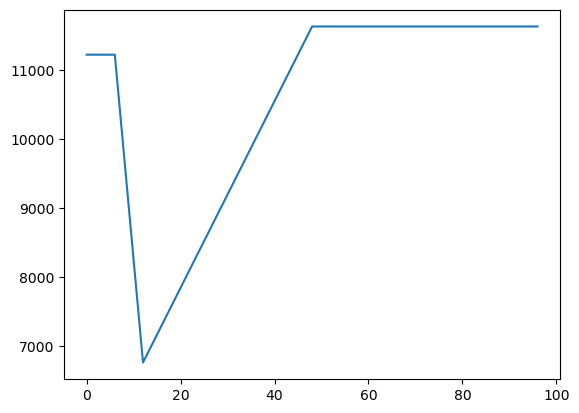

In [180]:
# Plot peptide levels over time
plt.plot(train.loc[942, "visit_month"], train.loc[942, "O00391"])
plt.show()

In [181]:
s = train.columns.values
e = ['upd23b_clinical_state_on_medication', 'visit_month']
norm_columns = set(train.columns.values)-set(e)
print(len(set(train.columns.values)))
print(len(set(train.columns.values)-set(e)))

1201
1199


In [182]:
# Now we shall normalize all the columns values with the exception of two columns
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']
for col in norm_columns:
    train[col] = (train[col] - train[col].min()) / (train[col].max() - train[col].min())    

train.head()

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,0.303030,0.150,0.174419,0.0,On,0.506663,0.385009,0.589438,0.577661,...,0.475128,0.592219,0.266399,0.148896,0.144114,0.519776,0.626289,0.454550,0.395872,0.202879
55,3,0.303030,0.175,0.290698,0.0,On,0.553258,0.355831,0.555836,0.575605,...,0.437318,0.532145,0.277691,0.153454,0.135841,0.464635,0.585936,0.465535,0.364930,0.244856
55,6,0.242424,0.250,0.395349,0.0,On,0.599854,0.326652,0.522234,0.573549,...,0.399509,0.472072,0.288983,0.158013,0.127568,0.409494,0.545584,0.476519,0.333988,0.286832
55,9,0.242424,0.225,0.348837,0.0,On,0.650957,0.379483,0.571733,0.559971,...,0.475800,0.557344,0.338447,0.160050,0.152329,0.476181,0.616161,0.473511,0.406751,0.295055
55,12,0.303030,0.250,0.476744,0.0,On,0.702060,0.432313,0.621233,0.546393,...,0.552091,0.642616,0.387911,0.162088,0.177089,0.542868,0.686737,0.470502,0.479514,0.303277


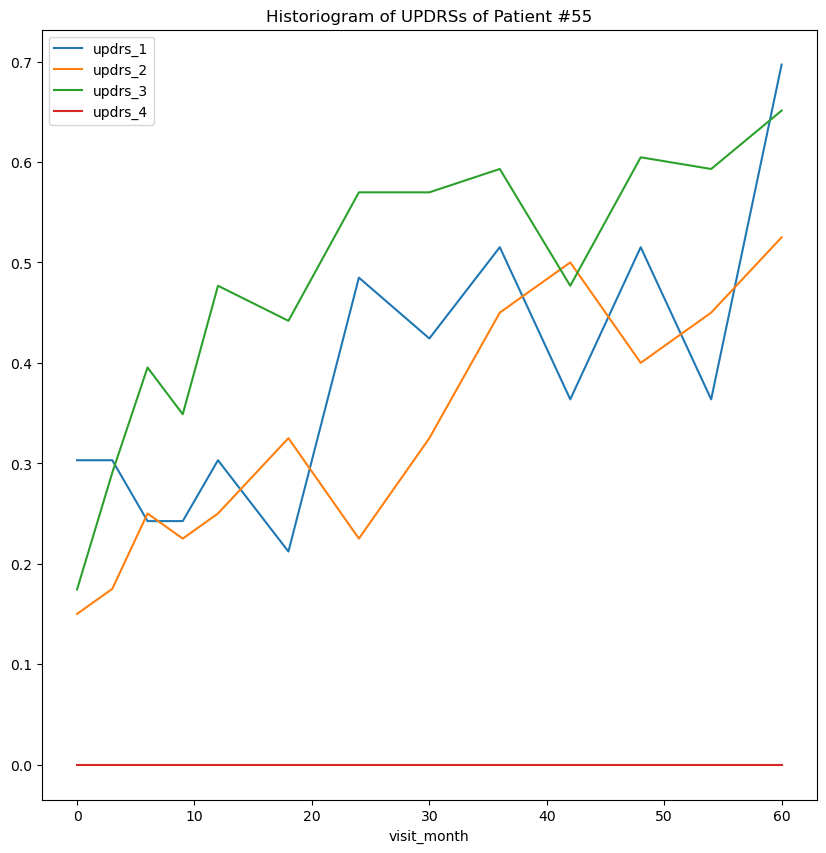

In [183]:
# We shall plot the evoltion of each updrs in time
patient = patient_id[0]
train.loc[patient].plot(x="visit_month", y=updrs_cols,
        kind="line", figsize=(10, 10))
plt.title(f'Historiogram of UPDRSs of Patient #{patient}')
plt.show() 

In [184]:
#  We shall define a linear regression method for each updrs
def linear_regressor_method(X,Y):
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    return linear_regressor

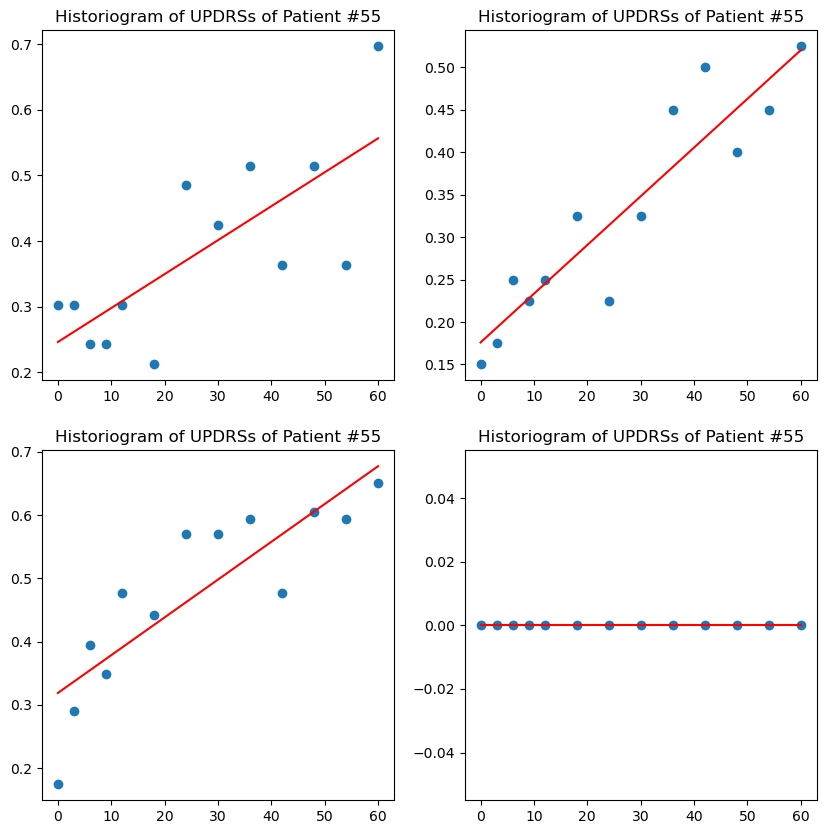

In [185]:
# Estimating updrs of one patient based on month_visit
# We shall invoke previous method 
linear_regressors_list = []
fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[patient]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[patient][updrs].values.reshape(-1, 1) 
    lr = linear_regressor_method(np_x, np_y)
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Historiogram of UPDRSs of Patient #{patient}')
    aux += 1

#TODO: Need to apply linear regression with all the proteins in the dataframe

Training set metrics:
	Training set of updrs_1 mean squared error: 0.03
	Training set of updrs_1 mean absolute error: 0.13
	Training set of updrs_1 R^2 score: 0.02
	Training set of updrs_2 mean squared error: 0.02
	Training set of updrs_2 mean absolute error: 0.13
	Training set of updrs_2 R^2 score: 0.02
	Training set of updrs_3 mean squared error: 0.03
	Training set of updrs_3 mean absolute error: 0.14
	Training set of updrs_3 R^2 score: 0.02
	Training set of updrs_4 mean squared error: 0.02
	Training set of updrs_4 mean absolute error: 0.08
	Training set of updrs_4 R^2 score: 0.03
Testing set metrics:
	Testing set of updrs_1 mean squared error: 0.03
	Testing set of updrs_1 mean absolute error: 0.14
	Testing set of updrs_1 R^2 score: -0.03
	Testing set of updrs_2 mean squared error: 0.02
	Testing set of updrs_2 mean absolute error: 0.12
	Testing set of updrs_2 R^2 score: 0.01
	Testing set of updrs_3 mean squared error: 0.03
	Testing set of updrs_3 mean absolute error: 0.14
	Testing se

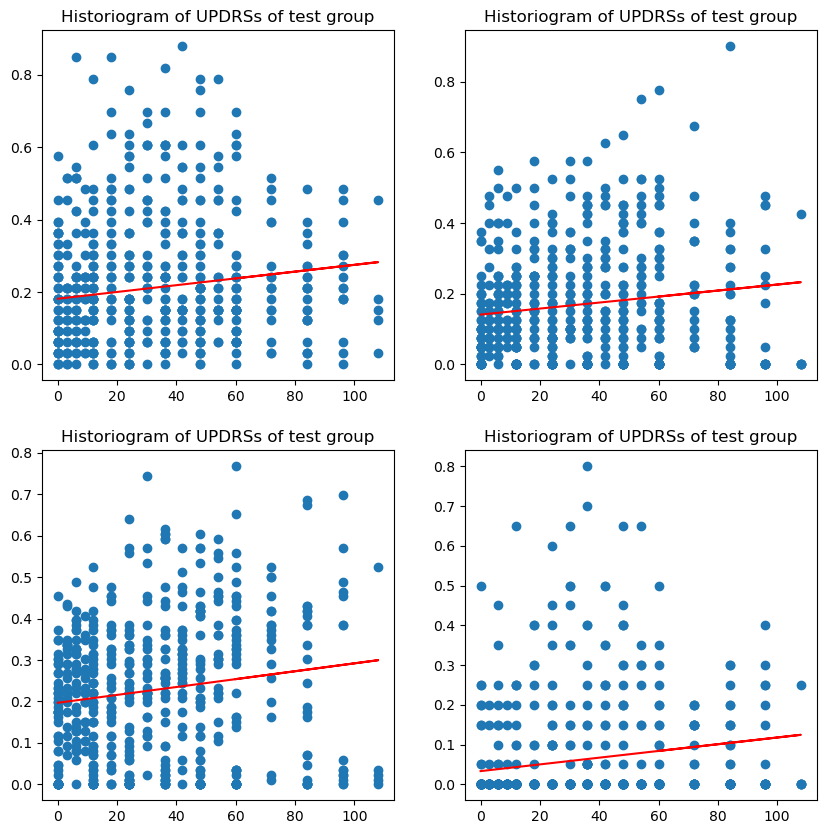

In [220]:
#training_length = round(len(patient_id)*0.8)
#testing_length  = len(patient_id)-round(len(patient_id)*0.8)
#train_lr = patient_id[0:training_length]
#test_lr  = patient_id[training_length:len(patient_id)]

from sklearn.model_selection import train_test_split

train_lr, test_lr = train_test_split(patient_id, test_size=50)




linear_regressors_list = []

print('Training set metrics:')
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[train_lr]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[train_lr][updrs].values.reshape(-1, 1)
    lr = linear_regressor_method(np_x, np_y)
    org_dict = { f'{updrs}': lr }
    linear_regressors_list.append(org_dict)
    y_pred = lr.predict(np_x)
    mse_train = mean_squared_error(np_y, y_pred)
    mae_train = mean_absolute_error(np_y, y_pred)
    # mape_train = mean_absolute_percentage_error(np_y, y_pred) * 100
    r2_train = r2_score(np_y, y_pred)
    print(f"\tTraining set of {updrs} mean squared error: {mse_train:.2f}")
    print(f"\tTraining set of {updrs} mean absolute error: {mae_train:.2f}")
    # print(f"\tTraining set of {updrs} mean absolute percentage error: {mape_train:.3f} %")
    print(f"\tTraining set of {updrs} R^2 score: {r2_train:.2f}")

fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
print('Testing set metrics:')
for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[test_lr]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[test_lr][updrs].values.reshape(-1, 1)
    lr   = linear_regressors_list[idx][f'{updrs}']
    # print(linear_regressors_list)
    y_pred = lr.predict(np_x)
    mse_test = mean_squared_error(np_y, y_pred)
    mae_test = mean_absolute_error(np_y, y_pred)
    # mape_test = mean_absolute_percentage_error(np_y, y_pred) * 100
    r2_test = r2_score(np_y, y_pred)
    print(f"\tTesting set of {updrs} mean squared error: {mse_test:.2f}")
    print(f"\tTesting set of {updrs} mean absolute error: {mae_test:.2f}")
    # print(f"\tTesting set of {updrs} mean absolute percentage error: {mape_test:.3f} %")
    print(f"\tTesting set of {updrs} R^2 score: {r2_test:.2f}")
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Historiogram of UPDRSs of test group')
    aux += 1

# Save the figure
fig.savefig("lr-all-updrs.png")



In [221]:
# Estimate linear regression of evolution od UPDRS over time on each patient

linear_regressors_df = pd.DataFrame({'intercept_1': pd.Series(dtype='float'),'intercept_2': pd.Series(dtype='float'),'intercept_3': pd.Series(dtype='float'),'intercept_4': pd.Series(dtype='float'), \
                                     'slope_1': pd.Series(dtype='float'),'slope_2': pd.Series(dtype='float'),'slope_3': pd.Series(dtype='float'),'slope_4': pd.Series(dtype='float')}, \
                                     index = patient_id)

#print(linear_regressors_df.head(10))

for patient_n, patient in enumerate(patient_id):
    #print('Training set metrics:')
    #print('Patient number:', patient)
    for idx, updrs in enumerate(updrs_cols):
        np_x = train.loc[patient]['visit_month'].values.reshape(-1, 1)
        np_y = train.loc[patient][updrs].values.reshape(-1, 1)
        lr = linear_regressor_method(np_x, np_y)
        org_dict = { f'{updrs}': lr }
        linear_regressors_df.loc[patient][idx] = lr.intercept_
        linear_regressors_df.loc[patient][4+idx] = lr.coef_
        y_pred = lr.predict(np_x)
        mse_train = mean_squared_error(np_y, y_pred)
        mae_train = mean_absolute_error(np_y, y_pred)
        # mape_train = mean_absolute_percentage_error(np_y, y_pred) * 100
        r2_train = r2_score(np_y, y_pred)
        #print(f"\tTraining set of {updrs} mean squared error: {mse_train:.2f}")
        #print(f"\tTraining set of {updrs} mean absolute error: {mae_train:.2f}")
        # print(f"\tTraining set of {updrs} mean absolute percentage error: {mape_train:.3f} %")
        #print(f"\tTraining set of {updrs} R^2 score: {r2_train:.2f}")

print(linear_regressors_df.head(10))

      intercept_1  intercept_2  intercept_3  intercept_4   slope_1  \
55       0.246186     0.175846     0.318765     0.000000  0.005173   
942      0.139597     0.047188     0.217091    -0.016655 -0.000523   
1517     0.511413     0.168398     0.303005     0.244805  0.001673   
1923     0.045455     0.003571     0.004568     0.000000  0.001082   
2660     0.031746     0.000000     0.007198     0.000000  0.002814   
3636     0.208203     0.159347     0.125241     0.040849  0.002109   
3863     0.231650     0.261667     0.442636     0.188889  0.004798   
4161     0.098039    -0.024718    -0.027041     0.000000  0.003565   
4172     0.032760     0.000000     0.000000     0.000000  0.000114   
4923     0.128099     0.059091     0.265328     0.027273  0.001974   

           slope_2   slope_3   slope_4  
55    5.742708e-03  0.005971  0.000000  
942   1.396882e-03  0.002066  0.000683  
1517  5.402237e-03  0.002756  0.002543  
1923  1.241495e-20  0.000484  0.000000  
2660  0.000000e+00  0.00

In [277]:
#Create the training database for XGBoost

training_data_XGB = train[(train["visit_month"] == 0)]
training_data_XGB = training_data_XGB.replace('On',1)
training_data_XGB = training_data_XGB.replace('Off',0)



x_training_XGB = training_data_XGB.loc[:, ~training_data_XGB.columns.isin(['visit_month',	'updrs_1',	'updrs_2',	'updrs_3',	'updrs_4'])]
x_training_XGB = x_training_XGB.loc[train_lr]

x_testing_XGB = training_data_XGB.loc[:, ~training_data_XGB.columns.isin(['visit_month',	'updrs_1',	'updrs_2',	'updrs_3',	'updrs_4'])]
x_testing_XGB = x_testing_XGB.loc[test_lr]
print(len(x_testing_XGB))
print(len(x_training_XGB))

#slope_training_XGB = training_data_XGB.loc[train_lr, training_data_XGB.columns.isin(['updrs_1',	'updrs_2',	'updrs_3',	'updrs_4'])]
#slope_testing_XGB = training_data_XGB.loc[test_lr, training_data_XGB.columns.isin(['updrs_1',	'updrs_2',	'updrs_3',	'updrs_4'])]


slope_training_XGB = linear_regressors_df.loc[train_lr]
slope_testing_XGB = linear_regressors_df.loc[test_lr]

print(slope_training_XGB.tail(5))
print(x_training_XGB.tail(5))
print(slope_testing_XGB.tail(5))
print(x_testing_XGB.tail(5))
print(slope_training_XGB.iloc[:,4])



50
198
       intercept_1  intercept_2  intercept_3  intercept_4   slope_1  \
57416     0.285107     0.215977     0.327913     0.620551 -0.001266   
7051      0.131451     0.160265     0.204871    -0.009339  0.004255   
15245     0.222187     0.175015     0.287708     0.180981  0.002127   
45181     0.217803     0.000000     0.024855     0.000000 -0.002210   
1923      0.045455     0.003571     0.004568     0.000000  0.001082   

            slope_2   slope_3   slope_4  
57416  8.458647e-04  0.000427 -0.009566  
7051   2.702871e-03  0.003659  0.001587  
15245  2.861556e-03  0.003036  0.000260  
45181  0.000000e+00 -0.000073  0.000000  
1923   1.241495e-20  0.000484  0.000000  
            upd23b_clinical_state_on_medication    O00391    O00533    O00584  \
patient_id                                                                      
57416                                         0  0.589629  0.275366  0.304467   
7051                                          0  0.535480  0.138795  0.

In [279]:
# Try to predict the regression values from proteins using XGBOOST
params = {
    "n_estimators": 500,
    "max_depth": 6,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

XGBmodel_list = []

for i in range(0,4):
    XGBmodel_list.append(ensemble.GradientBoostingRegressor(**params))
    XGBmodel_list[i].fit(x_training_XGB, slope_training_XGB.iloc[:,4+i])
    
    y_pred = XGBmodel_list[i].predict(x_testing_XGB)
    mae = mean_absolute_error(slope_testing_XGB.iloc[:,4+i], y_pred)
    print('Mean Absolute Percentage Error of updrs',i+1, 'slope:', mae)
    




Mean Absolute Percentage Error of updrs 1 slope: 0.001741187817229341
Mean Absolute Percentage Error of updrs 2 slope: 0.0016649183995272369
Mean Absolute Percentage Error of updrs 3 slope: 0.0016466685941427376
Mean Absolute Percentage Error of updrs 4 slope: 0.001458443389931813


Mean Absolute Error of updrs 1: 0.0013436643072481875


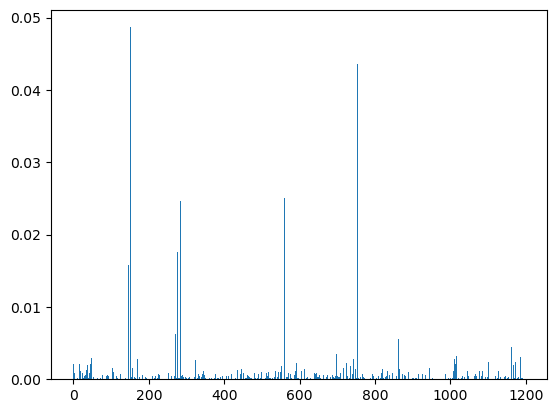

In [276]:
# Now we will use a regression model to predict the updrs based on protein levels
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Create a Random Forest Regressor object with default parameters
rf1 = RandomForestRegressor()

# Fit the model to the training data
rf1.fit(x_training_XGB, slope_training_XGB.iloc[:,7])

# Make predictions on the test data
y_pred = rf1.predict(x_testing_XGB)

# Evaluate the model using Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(slope_testing_XGB.iloc[:,7], y_pred)
print('Mean Absolute Error of updrs 1:', mae)

# plot feature importance graph
plt.bar(range(len(rf1.feature_importances_)), rf1.feature_importances_)
plt.show()

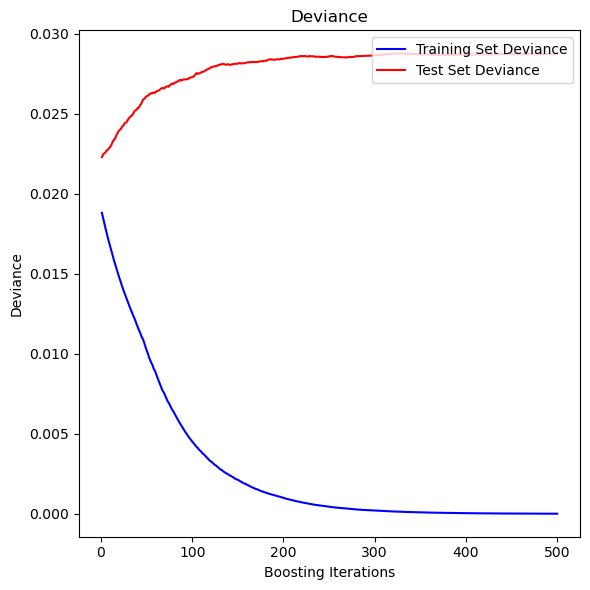

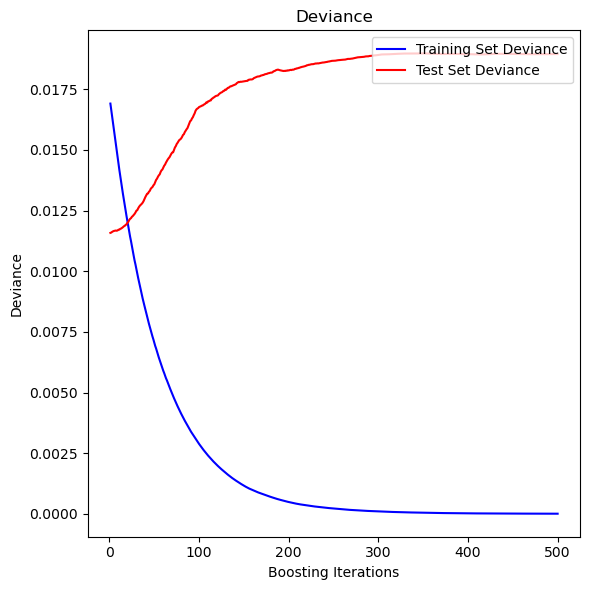

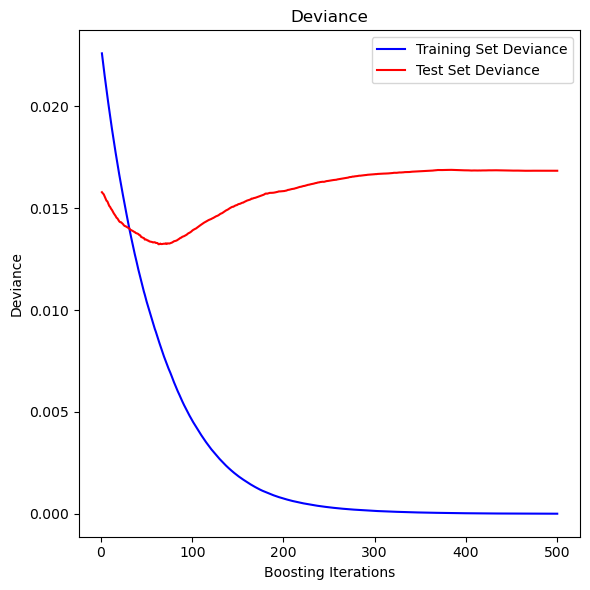

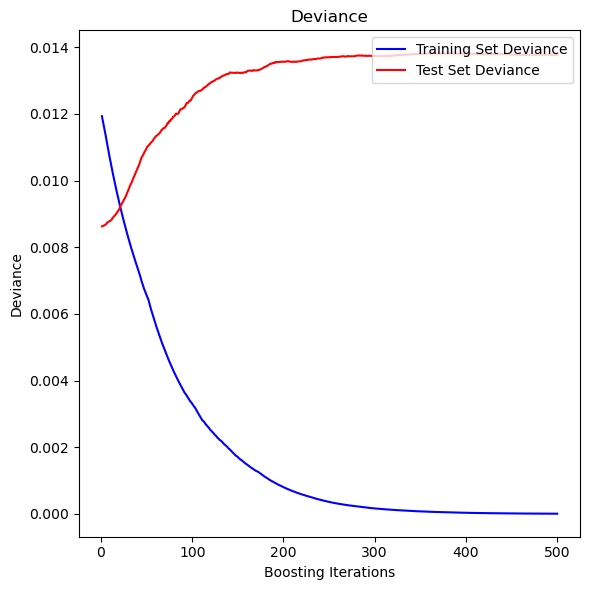

In [253]:
# Visualize the results

for updrs in range(0,4):
    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(XGBmodel_list[updrs].staged_predict(x_testing_XGB)):
        test_score[i] = mean_squared_error(slope_testing_XGB.iloc[:,updrs], y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        XGBmodel_list[updrs].train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()


In [119]:
print(train.columns[6:])

Index(['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791', 'O15240',
       'O15394', 'O43505', 'O60888',
       ...
       'YSLTYIYTGLSK', 'YTTEIIK', 'YVGGQEHFAHLLILR',
       'YVM(UniMod_35)LPVADQDQC(UniMod_4)IR', 'YVMLPVADQDQC(UniMod_4)IR',
       'YVNKEIQNAVNGVK', 'YWGVASFLQK', 'YYC(UniMod_4)FQGNQFLR', 'YYTYLIMNK',
       'YYWGGQYTWDMAK'],
      dtype='object', length=1195)


In [ ]:
print(train.updrs_1)

patient_id
55       0.303030
55       0.303030
55       0.242424
55       0.242424
55       0.303030
           ...   
65043    0.212121
65043    0.121212
65043    0.181818
65043    0.090909
65043    0.212121
Name: updrs_1, Length: 2615, dtype: float64


In [ ]:
print(y_pred)

[1.67333333e-01 2.76250000e-02 1.20000000e-02 4.50000000e-03
 9.50000000e-03 3.06916667e-01 9.00000000e-03 1.66441667e-01
 9.12464286e-02 5.00000000e-03 0.00000000e+00 1.92679654e-02
 9.77750000e-02 7.85950397e-02 5.19285714e-02 8.93333333e-02
 3.19166667e-02 8.71500000e-02 5.16666667e-03 1.24285714e-02
 2.17000000e-01 2.07500000e-02 3.97277778e-02 0.00000000e+00
 1.75000000e-02 1.05000000e-02 2.42500000e-02 5.42857143e-02
 1.86136905e-01 6.00000000e-03 5.41250000e-02 1.85000000e-02
 3.68125000e-02 1.26666667e-02 1.53333333e-02 0.00000000e+00
 2.82344048e-01 3.39196429e-02 2.35000000e-02 1.20000000e-03
 6.66666667e-03 7.33954545e-02 1.38091667e-01 5.10625000e-02
 1.83526209e-01 2.00000000e-02 4.60000000e-03 1.11288492e-01
 6.43333333e-03 5.00000000e-04 2.80166667e-02 9.25250000e-02
 0.00000000e+00 2.48033333e-01 0.00000000e+00 3.98809524e-02
 1.29857143e-01 2.15833333e-02 2.94750000e-02 2.11000000e-02
 3.00000000e-03 6.91666667e-03 3.60000000e-02 2.77777778e-03
 6.39041667e-02 1.940000

In [ ]:
print(y_test)

patient_id
64674    0.20
24820    0.05
56317    0.00
26210    0.00
49683    0.00
         ... 
13618    0.25
60326    0.00
12931    0.00
30416    0.05
64674    0.30
Name: updrs_4, Length: 523, dtype: float64


In [ ]:
# Load all datasets
test_proteins = pd.read_csv("./example_test_files/test_proteins.csv")
test_peptides = pd.read_csv("./example_test_files/test_peptides.csv")

# Pivot the proteins and peptides tables so each protein and peptide is a feature
test_proteins = test_proteins.pivot_table(values="NPX", index="visit_id", columns="UniProt")
test_peptides = test_peptides.pivot_table(values="PeptideAbundance", index="visit_id", columns="Peptide")

# Merge the three tables
test = test_proteins.merge(test_peptides, on="visit_id", how="left")

test.head()
# Set the patient id as index
# test = test.set_index(["patient_id"])

# test = test.drop("visit_id", axis=1)
# # Create a list of the ids of the patients
# patient_id_test = list(test.index.unique())

# # Interpolate the missing data of every patient
# for patient in patient_id_test:
#     test.loc[patient] = test.loc[patient].interpolate(method="linear").fillna(method="bfill")

# # Fill updrs and state of medication values
# test.updrs_4 = test.updrs_4.fillna(0)
# test.upd23b_clinical
# # Adjust updr4 values to possible values
# test.updrs_4 = round(test.updrs_4)

# # Check missing values after interpolate
# print("Total missing values left: {}".format(test.isna().sum().sum()))
# print(test.isna().sum().sort_values(ascending=False))
# # Fill the remaining na values with the mean of the columns
# test = test.fillna(test.mean())

# # s = test.columns.values
# # e = ['upd23b_clinical_state_on_medication', 'visit_month']
# # norm_columns = set(train.columns.values)-set(e)
# # print(len(set(train.columns.values)))
# # print(len(set(train.columns.values)-set(e)))

,O00391,O00533,O00584,O14498,O14773,O14791,O15031,O15240,O15394,O43505,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
3342_6,14564.0,616804.0,61418.1,27830.1,14959.2,2853.12,NaN,223373.0,58863.0,207497.0,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423_0,33127.9,490742.0,43615.3,NaN,16486.6,2882.42,11963.7,124344.0,57688.1,200364.0,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
